# Vinpearl Recruit Challenge Notebook
Candidate: **Truong Si Thi Vu**\
Python version: 3.11.4\
Notebook runtime: Approximately 3 minutes\
Github repository: https://github.com/vutruong99/VinpearlRecruitChallenge/

**Note:** This notebook only contains my code and simple comments explaining the process, for a more detailed document and *problem discussion*, please find my attached report.

# Problem Statement

*As a data scientist, I am given transaction data from the Rainbow Store and asked to predict which customers will make at least 1 purchase in a given month.*

In [1]:
# Import libraries
import json
import pandas as pd
import ast
import numpy as np
import datetime
import seaborn as sns
from xgboost import XGBClassifier
from functools import reduce
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format
from sklearn.metrics import roc_auc_score

In [2]:
# Read the csv file
dataframe = pd.read_csv("VinpearlRecruitChallenge_MLTrack_DataSet.csv")
dataframe

,csn,date,transaction_info
0,Y2NgaWJoYw==,2018-03-02,"[{'article': '10020163', 'salesquantity': 2.0,..."
1,Y2NgaWJoYw==,2018-03-04,"[{'article': '10026562', 'salesquantity': 3.0,..."
2,Y2NgaWlpYA==,2018-02-27,"[{'article': '10013531', 'salesquantity': 1.0,..."
3,Y2NgaWlpYA==,2018-03-16,"[{'article': '10008991', 'salesquantity': 1.0,..."
4,Y2NgaWlpYA==,2018-05-24,"[{'article': '10009698', 'salesquantity': 1.0,..."
...,...,...,...
131789,amxpamJk,2018-03-24,"[{'article': '10324916', 'salesquantity': 1.0,..."
131790,amxpamJk,2018-04-07,"[{'article': '10012785', 'salesquantity': 1.0,..."
131791,amxpamJk,2018-04-21,"[{'article': '10083185', 'salesquantity': 1.0,..."
131792,amxpamJk,2018-05-20,"[{'article': '10054789', 'salesquantity': 0.50..."


In [3]:
# Parse JSON strings and convert string dates into objects
curated_data_list = []

for index, row in dataframe.iterrows():
    csn = row["csn"]
    date = row["date"]
    parsed_date = datetime.datetime.strptime(date, '%Y-%m-%d')
    transaction_info_list = ast.literal_eval(row["transaction_info"])
    
    for transaction in transaction_info_list:
        article = transaction["article"]
        quantity = transaction["salesquantity"]
        price = transaction["price"]
        
        curated_data_list.append([csn,parsed_date,article,quantity,price])

curated_dataframe = pd.DataFrame(curated_data_list, columns = ["csn", "date", "article", "salesquantity", "price"]) 
curated_dataframe

,csn,date,article,salesquantity,price
0,Y2NgaWJoYw==,2018-03-02,10020163,2.00,18250.00
1,Y2NgaWJoYw==,2018-03-04,10026562,3.00,13000.00
2,Y2NgaWJoYw==,2018-03-04,10320883,2.00,43000.00
3,Y2NgaWlpYA==,2018-02-27,10013531,1.00,17800.00
4,Y2NgaWlpYA==,2018-02-27,10015613,1.00,5600.00
...,...,...,...,...,...
993507,amxpamJk,2018-05-20,10225636,0.18,51500.00
993508,amxpbWNk,2018-04-11,10016399,2.00,57700.00
993509,amxpbWNk,2018-04-11,10016834,1.00,97000.00
993510,amxpbWNk,2018-04-11,10018739,1.00,82500.00


# Explanatory Data Analysis
In this step, we aim to analyze the dataset to extract as much insight from it as possible so as to prepare better for data processing.

Firstly, we explore the data types of the dataset. We are mainly dealing with a date object and two numerical values.

In [4]:
# Show datatypes
curated_dataframe.dtypes

csn                      object
date             datetime64[ns]
article                  object
salesquantity           float64
price                   float64
dtype: object

Next, we check to see if there are any missing values so that we can impute them in later steps. It looks like our data is complete.

In [5]:
# Show missing data
curated_dataframe.isnull().sum()

csn              0
date             0
article          0
salesquantity    0
price            0
dtype: int64

Let us visualize the dataset by making some simple plots.

Text(0.5, 1.0, 'Sales quantity over time')

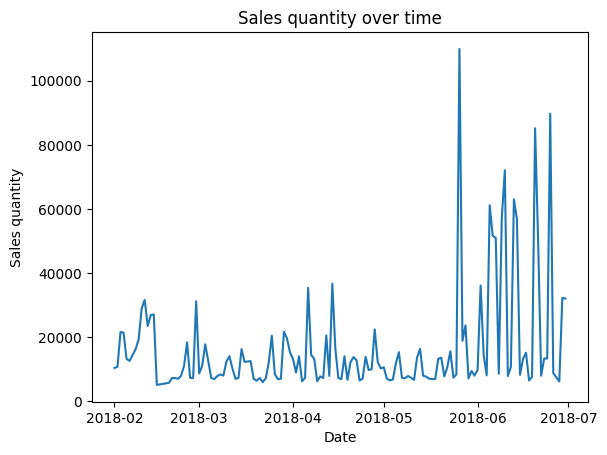

In [6]:
# Plot sales quantity over time
sns.lineplot(x = "date", y = "salesquantity", data = curated_dataframe.groupby("date", as_index = False)["salesquantity"].sum(), errorbar = None)
plt.xlabel("Date")
plt.ylabel("Sales quantity")
plt.title("Sales quantity over time")

Text(0.5, 1.0, 'Revenue over time')

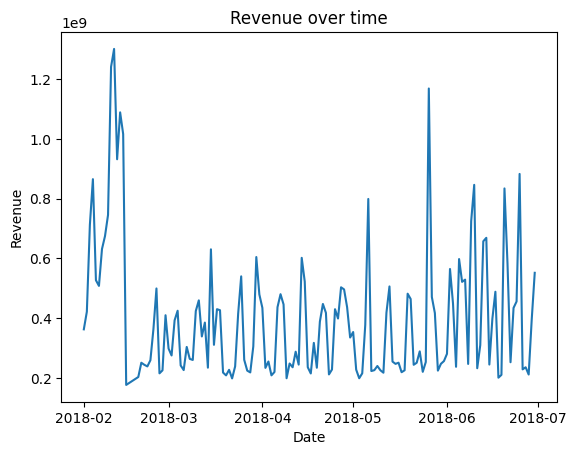

In [7]:
# Create monetary field and plot revenue over time
curated_dataframe["monetary"] = curated_dataframe["salesquantity"] * curated_dataframe["price"]
sns.lineplot(x = "date", y = "monetary", data = curated_dataframe.groupby("date", as_index = False)["monetary"].sum(), errorbar = None)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue over time")

Text(0.5, 1.0, 'Top 10 highest spending customers')

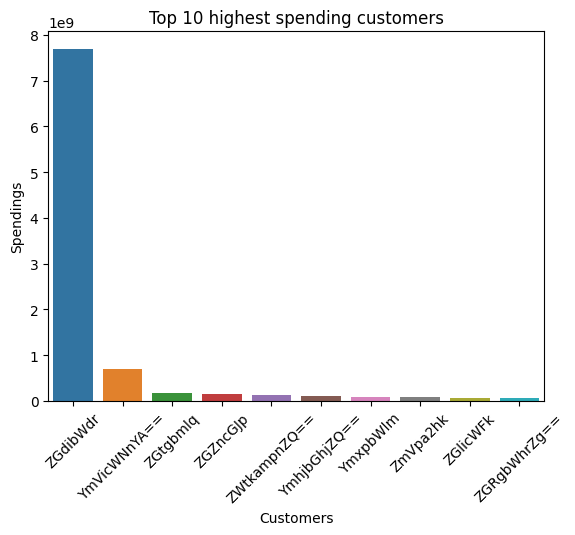

In [8]:
# Show the top 10 highest spending customers
sns.barplot(x = "csn", y = "monetary", data = curated_dataframe.groupby("csn", as_index = False)["monetary"].sum().sort_values("monetary", ascending = False)[:10])
plt.xticks(rotation = 45)
plt.xlabel("Customers")
plt.ylabel("Spendings")
plt.title("Top 10 highest spending customers")

Text(0.5, 1.0, 'Most sold items')

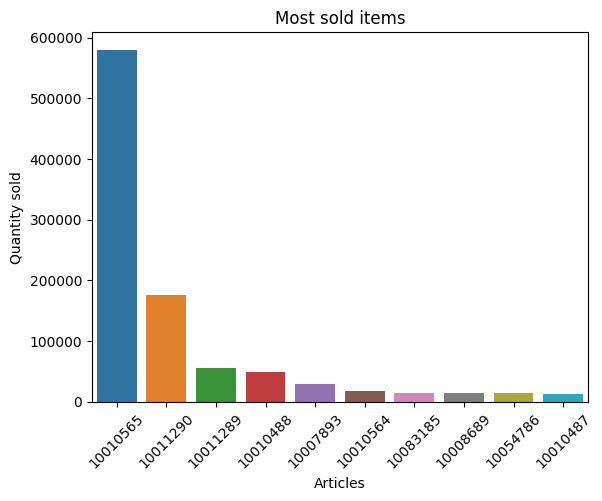

In [9]:
# Show the items that were sold the most
sns.barplot(x = "article", y = "salesquantity", data = curated_dataframe.groupby("article", as_index = False)["salesquantity"].sum().sort_values("salesquantity", ascending = False)[:10])
plt.xticks(rotation=45)
plt.xlabel("Articles")
plt.ylabel("Quantity sold")
plt.title("Most sold items")

Text(0.5, 1.0, 'Items that bring the most revenue')

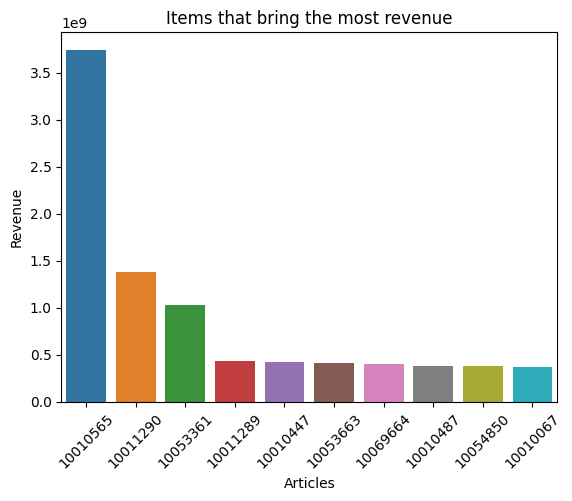

In [10]:
# Show the items that bring the most revenue
sns.barplot(x = "article", y = "monetary", data = curated_dataframe.groupby("article", as_index = False)["monetary"].sum().sort_values("monetary", ascending = False)[:10])
plt.xticks(rotation=45)
plt.xlabel("Articles")
plt.ylabel("Revenue")
plt.title("Items that bring the most revenue")

# Data Preprocessing
After exploring the data, we perform some basic feature engineering on the dataset to make useful features.

In [11]:
# Extract days, months, and years from date objects
curated_dataframe["day"] = curated_dataframe["date"].apply(lambda x: x.day)
curated_dataframe["month"] = curated_dataframe["date"].apply(lambda x: x.month)
curated_dataframe["year"] = curated_dataframe["date"].apply(lambda x: x.year)
curated_dataframe

,csn,date,article,salesquantity,price,monetary,day,month,year
0,Y2NgaWJoYw==,2018-03-02,10020163,2.00,18250.00,36500.00,2,3,2018
1,Y2NgaWJoYw==,2018-03-04,10026562,3.00,13000.00,39000.00,4,3,2018
2,Y2NgaWJoYw==,2018-03-04,10320883,2.00,43000.00,86000.00,4,3,2018
3,Y2NgaWlpYA==,2018-02-27,10013531,1.00,17800.00,17800.00,27,2,2018
4,Y2NgaWlpYA==,2018-02-27,10015613,1.00,5600.00,5600.00,27,2,2018
...,...,...,...,...,...,...,...,...,...
993507,amxpamJk,2018-05-20,10225636,0.18,51500.00,9373.00,20,5,2018
993508,amxpbWNk,2018-04-11,10016399,2.00,57700.00,115400.00,11,4,2018
993509,amxpbWNk,2018-04-11,10016834,1.00,97000.00,97000.00,11,4,2018
993510,amxpbWNk,2018-04-11,10018739,1.00,82500.00,82500.00,11,4,2018


In this problem, I use a technique called RFM analysis to predict customer behavior. RFM stands for Recency, Frequency, and Monetary. Basically, we assign scores to customers, allowing our model to make sense of information such as customers' order dates and items bought. We will extract RFM indexes from each customer using the following function:

In [12]:
def extract_rfm(target_month, year):
    """
    Function to compute Recency, Frequency, and Monetary from a dataframe, returns 4 dataframes, one for each feature
    and one for the merged data.
    
    parameters: target_month: The month that we are trying to make predictions on, in this case, valid values are: April,
                              May, June, and July (int).
                year: The year of the target month (int).
    """
    month_1 = target_month - 1
    month_2 = target_month - 2
    two_month_df = curated_dataframe[(curated_dataframe["year"]== year) & ((curated_dataframe["month"] == month_1) | (curated_dataframe["month"] == month_2))]
    
    # Recency calculation
    recency_df = two_month_df.groupby("csn", as_index = False)["date"].max()
    latest_date = two_month_df["date"].max() 
    recency_df["recency"] = recency_df["date"].apply(lambda x : (latest_date - x).days)
    recency_df = recency_df[["csn", "recency"]]
    
    # Frequency calculation
    frequency_df = two_month_df.groupby("csn")["csn"].count()
    frequency_df = frequency_df.reset_index(name="frequency")
    
    # Monetary calculation
    monetary_df = two_month_df.groupby("csn", as_index = False)["monetary"].sum()
    
    rfm_df = reduce(lambda x,y: pd.merge(x,y, on = "csn", how = "outer"), [recency_df, frequency_df, monetary_df])
    
    return rfm_df, recency_df, frequency_df, monetary_df

In this example, we are trying to predict which customers will make at least one purchase in April, therefore, the RFM function will extract RFM indexes in both February and March.

In [13]:
# Create the RFM dataframes
rfm_df, recency_df, frequency_df, monetary_df = extract_rfm(4,2018)
rfm_df

,csn,recency,frequency,monetary
0,Y2NgaWJoYw==,27,3,161500.00
1,Y2NgaWlpYA==,15,22,2091700.00
2,Y2NgamRpZA==,9,39,1476144.00
3,Y2NgamVj,6,3,33400.00
4,Y2Ngb2FpYg==,6,1,132217.00
...,...,...,...,...
13279,amxoamNp,6,10,190130.00
13280,amxocWRl,0,32,597727.99
13281,amxpa2Rr,14,64,2194253.00
13282,amxpaGRj,46,8,1017900.00


In [14]:
# Create a look up dictionary for a certain user's year and month (csn,year) : month
csn_month_dict = dict()

for index, row in curated_dataframe.iterrows():
    csn = row["csn"]
    year = row["year"]
    month = row["month"]
    if (csn,year) not in csn_month_dict: 
        csn_month_dict[(csn, year)] = set()
        csn_month_dict[(csn, year)].add(month)
    else:
        csn_month_dict[(csn, year)].add(month)

According to the problem, if there is a valid purchase from a customer in the following month (April), we identify them as a returning customer.

In [15]:
def label_data(df, target_month, year):
    """
    Function to decide whether or not a customer will indeed purchase something in the next month, returns a dataframe.
    Skip this step if the target month is July 2018.
    
    parameters: df: The RFM dataframe.
                target_month: The month that we are trying to make predictions on, in this case, valid values are: April,
                              May, June, and July (int).
                year: The year of the target month (int).
    """
    
    buy_next_month_bools = []

    for index, row in df.iterrows():
        csn = row["csn"]

        if target_month in csn_month_dict[(csn, year)]:
            buy_next_month_bools.append(1)
        else:
            buy_next_month_bools.append(0)
            
    df["buy_next_month"] = buy_next_month_bools
    
    return df

In [16]:
final_df = label_data(rfm_df.copy(), 4, 2018)
final_df

,csn,recency,frequency,monetary,buy_next_month
0,Y2NgaWJoYw==,27,3,161500.00,0
1,Y2NgaWlpYA==,15,22,2091700.00,0
2,Y2NgamRpZA==,9,39,1476144.00,0
3,Y2NgamVj,6,3,33400.00,0
4,Y2Ngb2FpYg==,6,1,132217.00,0
...,...,...,...,...,...
13279,amxoamNp,6,10,190130.00,0
13280,amxocWRl,0,32,597727.99,1
13281,amxpa2Rr,14,64,2194253.00,1
13282,amxpaGRj,46,8,1017900.00,0


# RFM Analysis
Before building the models, we will briefly look at our RFM indexes and divide our customers into different segments.

In [17]:
rfm_df

,csn,recency,frequency,monetary
0,Y2NgaWJoYw==,27,3,161500.00
1,Y2NgaWlpYA==,15,22,2091700.00
2,Y2NgamRpZA==,9,39,1476144.00
3,Y2NgamVj,6,3,33400.00
4,Y2Ngb2FpYg==,6,1,132217.00
...,...,...,...,...
13279,amxoamNp,6,10,190130.00
13280,amxocWRl,0,32,597727.99
13281,amxpa2Rr,14,64,2194253.00
13282,amxpaGRj,46,8,1017900.00


In [18]:
# Divide customers into 5 bins, with 5 being the highest rank
rfm_df['recency_score'] = pd.qcut(rfm_df['recency'], 5, [5,4,3,2,1])
rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency'], 5, [1,2,3,4,5])
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary'], 5, [1,2,3,4,5])
rfm_df['rfm_score'] = rfm_df["recency_score"].astype(str) + rfm_df["frequency_score"].astype(str) + rfm_df["monetary_score"].astype(str)
rfm_df["rfm_avg"] = (rfm_df["recency_score"].astype(float) + rfm_df["frequency_score"].astype(float) + rfm_df["monetary_score"].astype(float)) / 3
rfm_df

,csn,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,rfm_avg
0,Y2NgaWJoYw==,27,3,161500.00,2,1,1,211,1.33
1,Y2NgaWlpYA==,15,22,2091700.00,3,3,4,334,3.33
2,Y2NgamRpZA==,9,39,1476144.00,4,4,4,444,4.00
3,Y2NgamVj,6,3,33400.00,4,1,1,411,2.00
4,Y2Ngb2FpYg==,6,1,132217.00,4,1,1,411,2.00
...,...,...,...,...,...,...,...,...,...
13279,amxoamNp,6,10,190130.00,4,2,1,421,2.33
13280,amxocWRl,0,32,597727.99,5,4,3,543,4.00
13281,amxpa2Rr,14,64,2194253.00,3,5,4,354,4.00
13282,amxpaGRj,46,8,1017900.00,2,2,3,223,2.33


In RFM analysis, there are certain thresholds to determine the types of buyers. For example, a customer with all three scores greater than 4 would be considered a "Champion", while one with all three scores lower than 2 would be considered "Lost". In our case, customer "Y2Ngb2FpYg==" is categorized as a "New Customer".

In [19]:
# Create segments
rfm_df["segment"] = "low"
rfm_df.loc[rfm_df["rfm_avg"] >= 5*1/3, "segment"] = "normal"
rfm_df.loc[rfm_df["rfm_avg"] >= 5*2/3, "segment"] = "high"
rfm_df

,csn,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,rfm_avg,segment
0,Y2NgaWJoYw==,27,3,161500.00,2,1,1,211,1.33,low
1,Y2NgaWlpYA==,15,22,2091700.00,3,3,4,334,3.33,high
2,Y2NgamRpZA==,9,39,1476144.00,4,4,4,444,4.00,high
3,Y2NgamVj,6,3,33400.00,4,1,1,411,2.00,normal
4,Y2Ngb2FpYg==,6,1,132217.00,4,1,1,411,2.00,normal
...,...,...,...,...,...,...,...,...,...,...
13279,amxoamNp,6,10,190130.00,4,2,1,421,2.33,normal
13280,amxocWRl,0,32,597727.99,5,4,3,543,4.00,high
13281,amxpa2Rr,14,64,2194253.00,3,5,4,354,4.00,high
13282,amxpaGRj,46,8,1017900.00,2,2,3,223,2.33,normal


Text(0.5, 1.0, 'Customer segmentation')

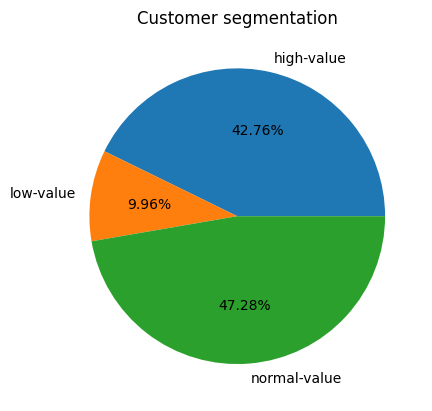

In [20]:
# Visualize the segments
plt.pie(rfm_df.groupby("segment")["segment"].count(), labels = ["high-value", "low-value", "normal-value"], autopct = "%.2f%%")
plt.title("Customer segmentation")

Looking at the graph, we can see that nearly 43% of the customers have a high rfm average scores. We can further divide the chart to create more segments hence improving our chance to target the right type of customers.

# Predictive Modeling
After getting the necessary features from the data, we continue by training some models for predictions.

In [21]:
# Prepare data for training and testing
X = final_df[["recency", "frequency", "monetary"]]
y = final_df[["buy_next_month"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

We turned the problem into a simple binary classification task, therefore, I will select a few candidates for comparison namely XGBoost, RandomForest, CatBoost, and LightGBM.

In [22]:
# Initialize and train XGBoost
xgb = XGBClassifier(n_estimators = 100, max_depth = 2)
xgb.fit(X_train, y_train, verbose = False)

# Make predictions and compute metrics
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))
xgb_report = classification_report(y_test, predictions, output_dict=True)
xgb_precision = xgb_report["1"]["precision"]
xgb_recall = xgb_report["1"]["recall"]
xgb_f1 = xgb_report["1"]["f1-score"]

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      2220
           1       0.77      0.63      0.69      2164

    accuracy                           0.72      4384
   macro avg       0.73      0.72      0.72      4384
weighted avg       0.73      0.72      0.72      4384

ROC AUC Score: 0.7830718888944397


In [23]:
# Initialize and train RandomForest
rfc = RandomForestClassifier(max_depth = 6)
rfc.fit(X_train, y_train.ravel())

# Make predictions and compute metrics
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))
rfc_report = classification_report(y_test, predictions, output_dict=True)
rfc_precision = rfc_report["1"]["precision"]
rfc_recall = rfc_report["1"]["recall"]
rfc_f1 = rfc_report["1"]["f1-score"]

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      2220
           1       0.77      0.64      0.70      2164

    accuracy                           0.73      4384
   macro avg       0.73      0.72      0.72      4384
weighted avg       0.73      0.73      0.72      4384

ROC AUC Score: 0.7856934106009892


In [24]:
# Initialize and train CatBoost
cbc = CatBoostClassifier(iterations = 1000, silent = True, allow_writing_files = False)
cbc.fit(X_train, y_train.ravel())

# Make predictions and compute metrics
predictions = cbc.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, cbc.predict_proba(X_test)[:, 1]))
cbc_report = classification_report(y_test, predictions, output_dict=True)
cbc_precision = cbc_report["1"]["precision"]
cbc_recall = cbc_report["1"]["recall"]
cbc_f1 = cbc_report["1"]["f1-score"]

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      2220
           1       0.76      0.65      0.70      2164

    accuracy                           0.73      4384
   macro avg       0.73      0.73      0.73      4384
weighted avg       0.73      0.73      0.73      4384

ROC AUC Score: 0.7817174151970825


In [25]:
# Initialize and train LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train.ravel())

# Make predictions and compute metrics
predictions = lgbm.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))
lgbm_report = classification_report(y_test, predictions, output_dict=True)
lgbm_precision = lgbm_report["1"]["precision"]
lgbm_recall = lgbm_report["1"]["recall"]
lgbm_f1 = lgbm_report["1"]["f1-score"]

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      2220
           1       0.75      0.64      0.69      2164

    accuracy                           0.72      4384
   macro avg       0.72      0.72      0.71      4384
weighted avg       0.72      0.72      0.72      4384

ROC AUC Score: 0.7785809145559608


In [26]:
# Visualize results
models = ["XGBoost", "CatBoost", "LightGBM", "RandomForest"]
precisions= [xgb_precision, cbc_precision, lgbm_precision, rfc_precision]
recalls = [xgb_recall, cbc_recall, lgbm_recall, rfc_recall]
f1scores = [xgb_f1, cbc_f1, lgbm_f1, rfc_f1]

result_df = pd.DataFrame(list(zip(models, precisions, recalls, f1scores)),columns =["model", "precision", "recall", "f1 score"])
result_df = pd.melt(result_df, id_vars = "model", var_name = "metric", value_name = "score")

Text(0.5, 1.0, 'Results comparison')

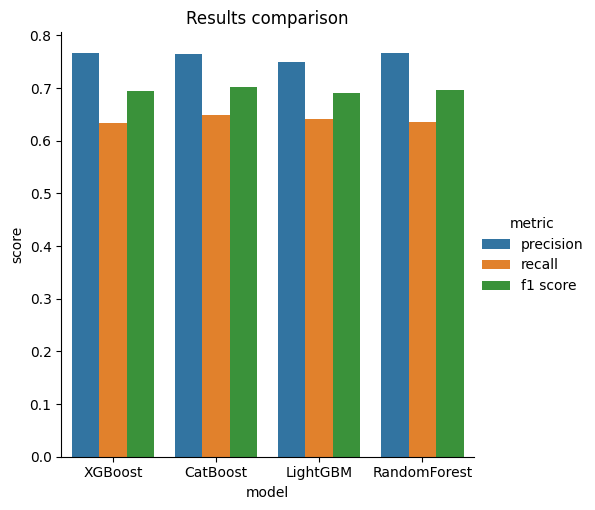

In [27]:
sns.catplot(x = "model", y = "score", hue = "metric", data = result_df, kind = "bar")
plt.title("Results comparison")

From observation, it seems like our models' performances are quite similar. In other cases, we would see a clear difference in the results, but for simplicity, I will choose XGBoost as our main model.

# Inference
Once we complete selecting the suitable model, let us test it on a couple of scenarios. 


**Scenario 1: Target month = June, year = 2018**

In [28]:
rfm_df, recency_df, frequency_df, monetary_df = extract_rfm(6,2018)
final_df = label_data(rfm_df.copy(), 6, 2018)
final_df

,csn,recency,frequency,monetary,buy_next_month
0,Y2NgaWlpYA==,7,4,485800.00,0
1,Y2NgamRpZA==,9,15,1479360.00,1
2,Y2NgbWFn,5,62,1984231.00,1
3,Y2NgbWRn,2,2,103500.00,0
4,Y2NgbWVlYA==,9,5,65861.00,1
...,...,...,...,...,...
12708,amxocWRl,50,12,282340.00,0
12709,amxpa2Rr,5,61,1270664.00,1
12710,amxpaWZo,39,10,477605.00,0
12711,amxpamJk,11,23,813227.00,0


In [29]:
# Prepare data for training and testing
X = final_df[["recency", "frequency", "monetary"]]
y = final_df[["buy_next_month"]].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [30]:
# Initialize and train XGBoost
xgb = XGBClassifier(n_estimators = 100, max_depth = 2)
xgb.fit(X_train, y_train, verbose = False)

# Make predictions and compute metrics
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      2101
           1       0.75      0.65      0.70      2095

    accuracy                           0.72      4196
   macro avg       0.72      0.72      0.72      4196
weighted avg       0.72      0.72      0.72      4196

ROC AUC Score: 0.7781044144224991


**Scenario 2: Target month = July, year = 2018**\
In this case, we do not have access to the true labels and only make predictions based on the data from May and June.

In [31]:
rfm_df, recency_df, frequency_df, monetary_df = extract_rfm(7,2018)
rfm_df

,csn,recency,frequency,monetary
0,Y2NgaWlpYA==,37,4,485800.00
1,Y2NgamRpZA==,2,57,3684699.03
2,Y2Ngb2FpYg==,20,24,619555.00
3,Y2Ngb2Ns,5,15,857401.00
4,Y2Ngb2RpaA==,8,11,553700.00
...,...,...,...,...
12870,amxnamZl,7,22,786510.00
12871,amxoaWFm,27,30,1622075.00
12872,amxoamNp,49,2,119000.00
12873,amxpa2Rr,13,39,927838.00


In [32]:
# Prepare data for predictions
X_test = rfm_df[["recency", "frequency", "monetary"]]

In [33]:
# Make predictions
predictions = xgb.predict(X_test)
csn = rfm_df["csn"]

predicted_customers = []

i = 0
for customer in csn:
    if predictions[i] == 1:
        predicted_customers.append(customer)
    i += 1

In [34]:
# Show the first 10 customers
predicted_customers[:10]

['Y2NgamRpZA==',
 'Y2Ngb2FpYg==',
 'Y2Ngb2Ns',
 'Y2NgbWFn',
 'Y2NgcGlqZQ==',
 'Y2NhaGNkaA==',
 'Y2NhaGRpaA==',
 'Y2NhamNqYg==',
 'Y2Nhb2I=',
 'Y2Nhb2djZw==']

# Conclusion

Based on the model results, we covered around 77% of the ground truth, meaning of 100 customers who will make a purchase next month, we successfully identified 77 of them. Our recall metric indicates that we did not do a great job finding customers who will come back. Generally, an AUC score that is greater than 0.75 is considered decent and that of our model varies from 0.78 to 0.80, which is acceptable. Additionally, we extracted some information on customer behavior from the visualizations and analysis.

Regarding the project, there is room for further improvements. For example, a wider range of models can be selected and from them, we can select the best model more easily. Also, hyperparameter tuning can be applied for each model to find its best settings, hence giving better results. 

If a text file containing predictions for July is required, please uncomment and run the following cell:

In [35]:
# with open("predicted_customers.txt", 'w') as f:
#     f.write("csn\n")
#     for customer in predicted_customers:
#         f.write(customer + "\n")

Thank you for your time and consideration.